# Inference tests

In [2]:
!hostname
!python -c "import jax; print(jax.default_backend(), jax.devices())"
# !nvidia-smi
# numpyro.set_platform("gpu")

import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.33' # NOTE: jax preallocates GPU (default 75%)

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax import random, jit, vmap, grad

import numpyro
import numpyro.distributions as dist
from numpyro.handlers import seed, condition, trace

%matplotlib inline
%load_ext autoreload 
%autoreload 2

feynmangpu04.cluster.local


gpu [cuda(id=0)]


## Toy model

Out of any model, build mixture sampler and mixture logprob.

In [40]:
init_key = random.PRNGKey(0)
dim = 2
radius = 3
loc = radius * jnp.ones(dim) / dim**0.5
mode1 = dist.MultivariateNormal(loc=loc, covariance_matrix=jnp.eye(dim))
mode2 = dist.MultivariateNormal(loc= -loc, covariance_matrix=jnp.eye(dim))
cat = dist.Categorical(jnp.array([.75, .25]))
mixture = dist.MixtureGeneral(cat, [mode1, mode2])

mixture_samples = mixture.sample(init_key, (1000,))
lw = mixture.log_prob(mixture_samples)

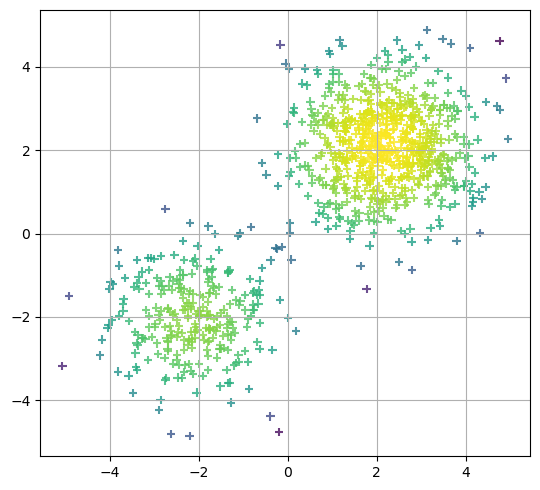

In [41]:
plt.figure(figsize=(5.5,5))
plt.scatter(*mixture_samples[:, :2].T, c=lw, marker='+', alpha=.8)
plt.grid()
plt.tight_layout()
plt.show();

Now same but in a numpyro model.

In [55]:
def mixture_model(dim=2, 
                  radius=3):
    loc = radius * jnp.ones(dim) / dim**0.5 # same euclidiean distance between modes for any dim
    mode1 = dist.MultivariateNormal(loc=loc, covariance_matrix=jnp.eye(dim))
    mode2 = dist.MultivariateNormal(loc= -loc, covariance_matrix=jnp.eye(dim))
    cat = dist.Categorical(jnp.array([.75, .25]))
    mixture = dist.MixtureGeneral(cat, [mode1, mode2])
    return numpyro.sample('mixt', mixture)

sample_fn = vmap(lambda rng_key, model_kwargs: seed(mixture_model, rng_key)(**model_kwargs), in_axes=(0, None))

from numpyro.infer.util import log_density
logp_fn = vmap(lambda mixt_val, model_kwargs: 
               log_density(model=mixture_model, 
                            model_args=(), 
                            model_kwargs=model_kwargs, 
                            params={'mixt':mixt_val})[0],
                in_axes=(0, None))

model_kwargs = {'dim':2, 'radius':3}
samples = sample_fn(random.split(init_key, 1000), model_kwargs)
logp = logp_fn(samples, model_kwargs)

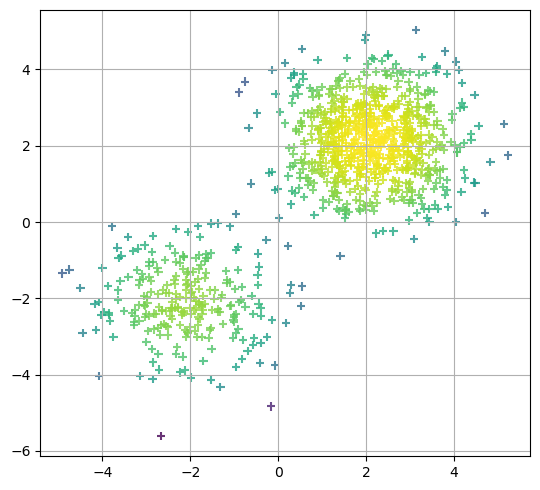

In [56]:
plt.figure(figsize=(5.5,5))
plt.scatter(*samples[:, :2].T, c=logp, marker='+', alpha=.8)
plt.grid()
plt.tight_layout()
plt.show();